In [239]:
%matplotlib inline

import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display

pd.set_option('expand_frame_repr', False)

In [122]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue   [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green  [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red    [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown  [10,11]
             (227, 119, 194), (247, 182, 210), # pink   [12,13]
             (127, 127, 127), (199, 199, 199), # gray   [14,15]
             (188, 189, 34 ), (219, 219, 141), # yellow [16,17]
             (23 , 190, 207), (158, 218, 229)] # cyan   [18,19]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [123]:
def load_data(rdir):
    sessions = {}
    experiments = {}
    start = rdir.rfind(os.sep)+1
    for path, dirs, files in os.walk(rdir):
        folders = path[start:].split(os.sep)
        if len(path[start:].split(os.sep)) == 2:
            sid = os.path.basename(glob.glob('%s/*.json' % path)[0])[:-5]
            if sid not in sessions.keys():
                sessions[sid] = {}
            sessions[sid] = ra.Session(sid, 'radical.pilot', src=path)
            experiments[sid] = folders[0]
    return sessions, experiments

# Load experiments' dataset into ra.session objects
# stored in a DataFrame.
rdir = 'data/'
sessions, experiments = load_data(rdir)
sessions = pd.DataFrame({'session': sessions,
                         'experiment': experiments})

In [124]:
pd.set_option('display.max_rows', None)

# Session

In [125]:
for sid in sessions.index:
    sessions.ix[sid, 'TTC'] = sessions.ix[sid, 'session'].ttc

In [126]:
for sid in sessions.index:
    sessions.ix[sid, 'nunit'] = len(sessions.ix[sid, 'session'].filter(etype='unit', inplace=False).get())

# Pilots

In [128]:
# Model of TOTAL pilot durations.
ttpdm = {'TT_PILOT_PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
         'TT_PILOT_PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
         'TT_PILOT_LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
         'TT_PILOT_LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
         'TT_PILOT_LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                                 'CANCELED',
                                                                 'FAILED']]}

# Add total pilot durations to sessions' DF.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for d in ttpdm.keys():
        sessions.ix[sid, d] = s.duration(ttpdm[d])

In [8]:
sessions

,experiment,session,TTC,nunit,TT_PILOT_LRMS_QUEUING,TT_PILOT_LRMS_SUBMITTING,TT_PILOT_PMGR_QUEUING,TT_PILOT_PMGR_SCHEDULING,TT_PILOT_LRMS_RUNNING
rp.session.radical.mingtha.017033.0007,exp1,<radical.analytics.session.Session object at 0...,1596.3935,16.0,448.9312,40.8441,0.0021,0.1115,1331.9196
rp.session.radical.mingtha.017033.0008,exp1,<radical.analytics.session.Session object at 0...,4904.5828,64.0,172.4000,32.6656,0.0019,0.1159,4716.4960
rp.session.radical.mingtha.017033.0009,exp1,<radical.analytics.session.Session object at 0...,2796.6535,32.0,235.8966,30.7743,0.0022,0.1041,2603.0602
rp.session.radical.mingtha.017034.0002,exp1,<radical.analytics.session.Session object at 0...,6110.7223,64.0,231.2612,25.5676,0.0021,0.1143,5939.8338
rp.session.radical.mingtha.017034.0003,exp1,<radical.analytics.session.Session object at 0...,1802.5047,16.0,229.3836,27.1441,0.0022,0.1173,1613.6261
rp.session.radical.mingtha.017034.0004,exp1,<radical.analytics.session.Session object at 0...,3428.5537,32.0,230.0107,26.4455,0.0020,0.1200,3223.5324
rp.session.radical.mingtha.017034.0005,exp1,<radical.analytics.session.Session object at 0...,2377.8985,16.0,247.5876,26.2371,0.0021,0.1347,2137.6839
rp.session.radical.mingtha.017034.0006,exp1,<radical.analytics.session.Session object at 0...,3419.9937,32.0,257.3524,25.5355,0.0021,0.1218,3203.5055
rp.session.radical.mingtha.017035.0003,exp1,<radical.analytics.session.Session object at 0...,1874.7339,16.0,269.2108,25.5982,0.0022,0.1030,1637.4107
rp.session.radical.mingtha.017035.0005,exp1,<radical.analytics.session.Session object at 0...,5680.6695,64.0,245.1551,25.7160,0.0020,0.1026,5473.1517


In [129]:
# Model of pilot durations.
pdm = {'PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
       'PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
       'LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
       'LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
       'LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                      'CANCELED',
                                                      'FAILED']]}

# DataFrame structure for pilot durations. 
pds = { 'pid': [],
        'sid': [],
        'experiment'     : [],
        'PMGR_SCHEDULING': [],
        'PMGR_QUEUING'   : [],
        'LRMS_SUBMITTING': [],
        'LRMS_QUEUING'   : [],
        'LRMS_RUNNING'   : []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for p in s.list('uid'):
        sf = s.filter(uid=p, inplace=False)        
        pds['pid'].append(p)
        pds['sid'].append(sid)
        pds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in pdm.keys():
            if (not sf.timestamps(state=pdm[d][0]) or 
                not sf.timestamps(state=pdm[d][1])):
                pds[d].append(None)
                continue
            pds[d].append(sf.duration(pdm[d]))

# Populate the DataFrame.
pilots = pd.DataFrame(pds)

In [10]:
pilots

,LRMS_QUEUING,LRMS_RUNNING,LRMS_SUBMITTING,PMGR_QUEUING,PMGR_SCHEDULING,experiment,pid,sid
0,217.1893,1330.8070,40.8441,0.0021,0.1115,exp1,pilot.0002,rp.session.radical.mingtha.017033.0007
1,220.5954,1321.0085,40.8441,0.0021,0.1115,exp1,pilot.0003,rp.session.radical.mingtha.017033.0007
2,448.9312,1096.9671,40.8441,0.0021,0.1115,exp1,pilot.0000,rp.session.radical.mingtha.017033.0007
3,275.0083,1274.1006,40.8441,0.0021,0.1115,exp1,pilot.0001,rp.session.radical.mingtha.017033.0007
4,172.3086,4668.0595,32.6656,0.0019,0.1159,exp1,pilot.0002,rp.session.radical.mingtha.017033.0008
5,172.4000,4670.0795,32.6656,0.0019,0.1159,exp1,pilot.0003,rp.session.radical.mingtha.017033.0008
6,171.3112,4665.8320,32.6656,0.0019,0.1159,exp1,pilot.0000,rp.session.radical.mingtha.017033.0008
7,125.9835,4708.0529,32.6656,0.0019,0.1159,exp1,pilot.0001,rp.session.radical.mingtha.017033.0008
8,153.8039,2601.0478,30.7743,0.0022,0.1041,exp1,pilot.0002,rp.session.radical.mingtha.017033.0009
9,235.8966,2517.9505,30.7743,0.0022,0.1041,exp1,pilot.0003,rp.session.radical.mingtha.017033.0009


In [130]:
def parse_osg_hostid(hostid):
    '''
    Heuristic: eliminate node-specific information from hostID.
    '''
    domain = None
    
    # Split domain name from IP.
    host = hostid.split(':')

    # Split domain name into words.
    words = host[0].split('.')

    # Get the words in the domain name that do not contain 
    # numbers. Most hostnames have no number but there are 
    # exceptions.
    literals = [l for l in words if not any((number in set('0123456789')) for number in l)]            

    # Check for exceptions: 
    # a. every word of the domain name has a number
    if len(literals) == 0:

        # Some hostname use '-' instead of '.' as word separator.
        # The parser would have returned a single word and the 
        # any of that word may have a number.
        if '-' in host[0]:
            words = host[0].split('-')
            literals = [l for l in words if not any((number in set('0123456789')) for number in l)]

            # FIXME: We do not check the size of literals. 
            domain = '.'.join(literals)

        # Some hostnames may have only the name of the node. We
        # have to keep the IP to decide later on whether two nodes
        # are likely to belong to the same cluster.
        elif 'nod' in host[0]:
            domain = '.'.join(host)

        # FIXME: ad hoc parsing
        elif 'n0'  in host[0]:
            domain = 'n0x.10.2.x.x'
            
        # The hostname is identified by an alphanumeric string
        else:
            domain = '.'.join(host)

    # Some hostnames DO have numbers in their name.
    elif len(literals) == 1:
        domain = '.'.join(words[1:])

    # Some hostname are just simple to parse.
    else:
        domain = '.'.join(literals)

    return domain

In [131]:
for pix in pilots.index:
    sid = pilots.ix[pix,'sid']
    pid = pilots.ix[pix,'pid']
    pls = sessions.ix[sid, 'session'].filter(uid=pid, inplace=False).get(etype=['pilot'])
    if len(pls) != 1:
        print "Error: session filter on uid returned multiple pilots"
        break
    if pls[0].cfg['hostid']:
        domain = parse_osg_hostid(pls[0].cfg['hostid'])
    else:
        domain = np.nan
    # print '%s: %s: %s: %s' % (pix, sid, pid, domain)
    pilots.ix[pix,'domain'] = domain

In [ ]:
pilots

In [132]:
# Temporary: workaround for bug ticket \#15. Calculates 
# the number of active pilots by looking into the 
# length of the list returned by timestamp on the 
# PMGR_ACTIVE state.

for sid in sessions.index:
    sessions.ix[sid, 'npilot_active'] = len(sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False).timestamps(state='PMGR_ACTIVE'))

In [133]:
# Add number of unique resorces per session.

for sid in sessions.index:
    sessions.ix[sid, 'n_unique_host'] = len(pilots[pilots['sid'] == sid]['domain'].unique())

# Units

In [134]:
# Model of unit durations.
udm = {'TT_UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       'TT_UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       'TT_IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       'TT_IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       'TT_IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       'TT_IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       'TT_IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       'TT_UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       'TT_UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       'TT_UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       'TT_UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'], 
       'TT_OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       'TT_OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       'TT_OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       'TT_OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

# Calculate total unit durations for each session.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for d in udm.keys():
        sessions.ix[sid, d] = s.duration(udm[d])

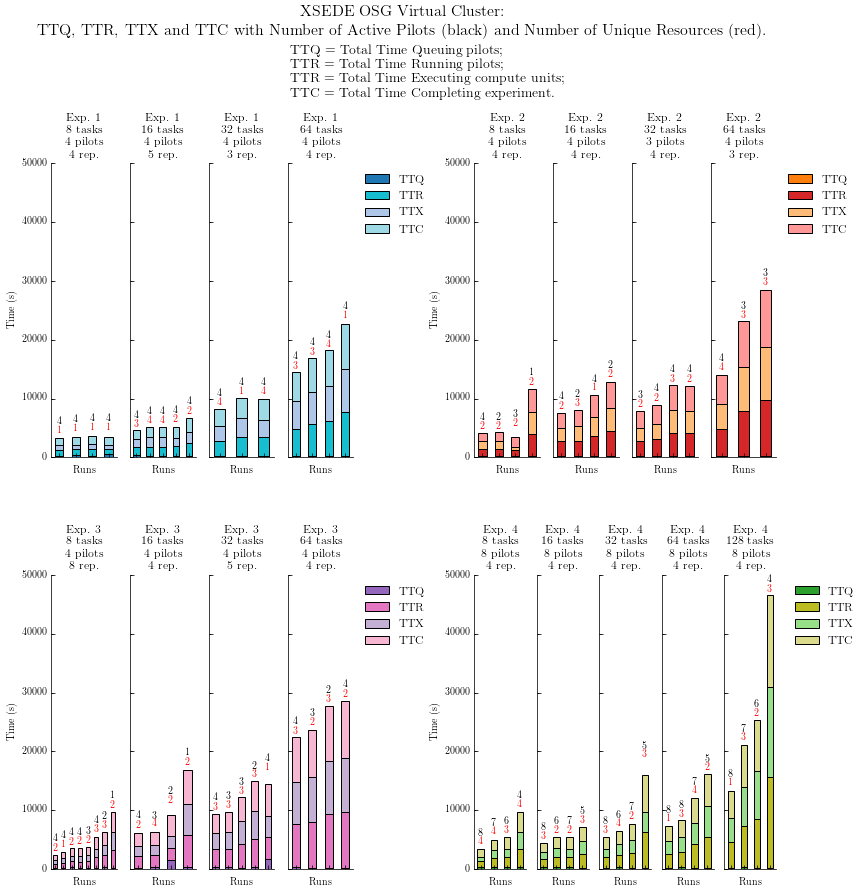

In [53]:
fig = plt.figure(figsize=(13,14))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttx': 'TTR = Total Time Executing compute units',
        'ttc': 'TTC = Total Time Completing experiment'}
defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

gs = []
grid  = gridspec.GridSpec(2, 2)
grid.update(wspace=0.4, hspace=0.4, top=0.825)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunit'].sort_values().unique():
        if not sessions[ (sessions['experiment'] == exp) & 
                 (sessions['nunit'] == nun) ].empty:
            ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                          (sessions['nunit'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0] ,tableau20[18],tableau20[1] ,tableau20[19]],
          'exp2': [tableau20[2] ,tableau20[6] ,tableau20[3] ,tableau20[7] ],
          'exp3': [tableau20[8] ,tableau20[12],tableau20[9] ,tableau20[13]],
          'exp4': [tableau20[4] ,tableau20[16],tableau20[5] ,tableau20[17]],
          'exp5': [tableau20[10],tableau20[14],tableau20[11],tableau20[15]]}

nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(4):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunit'].unique()[0])
            npilots = int(session[session['experiment'] == experiment]['npilot_active'][0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TT_UNIT_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 16:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.70, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           (height*3)+1500, label, ha='center', 
                           va='bottom')

            # Add labels with number of unique resources per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['n_unique_host']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height*3, label, ha='center', 
                           va='bottom', color='red')

            fig.add_subplot(ax[i])
            i += 1

# Analysis Unit Execution Time (Tx)

In [135]:
# Model of unit durations.
# udm = {'UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
#        'UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
#        'IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
#        'IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
#        'IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
#        'IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
#        'IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
#        'UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
#        'UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
#        'UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
#        'UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'],
#        'OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
#        'OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
#        'OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
#        'OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

udm = {'UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING']}
        
# DataFrame structure for pilot durations. 
# uds = { 'pid': [],
#         'sid': [],
#         'experiment' : [],
#         'UNIT_UMGR_SCHEDULING'   : [],
#         'UNIT_UMGR_BINDING'      : [],
#         'IF_UMGR_SCHEDULING'     : [], 
#         'IF_UMGR_QUEING'         : [],
#         'IF_AGENT_SCHEDULING'    : [],
#         'IF_AGENT_QUEUING'       : [], 
#         'IF_AGENT_TRANSFERRING'  : [],
#         'UNIT_AGENT_QUEUING'     : [],
#         'UNIT_AGENT_SCHEDULING'  : [], 
#         'UNIT_AGENT_QUEUING_EXEC': [], 
#         'UNIT_AGENT_EXECUTING'   : [], 
#         'OF_AGENT_QUEUING'       : [], 
#         'OF_UMGR_SCHEDULING'     : [],
#         'OF_UMGR_QUEUING'        : [],
#         'OF_UMGR_TRANSFERRING'   : []}

uds = { 'uid': [],
        'sid': [],
        'experiment': [],
        'UNIT_AGENT_EXECUTING': []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions[['session', 'experiment']].index:
#     if sessions.ix[sid, 'experiment'] in ['exp1','exp2']:
#         continue
#     print '%s - %s' % (sessions.ix[sid, 'experiment'], sid)
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for u in s.list('uid'):
#         print "\t%s" % u
        sf = s.filter(uid=u, inplace=False)
        uds['uid'].append(u)
        uds['sid'].append(sid)
        uds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in udm.keys():
            # print '\t\t%s' % udm[d]
            # print '\t\t[%s, %s]' % (sf.timestamps(state=udm[d][0]), sf.timestamps(state=udm[d][1])) 
            if (not sf.timestamps(state=udm[d][0]) or 
                not sf.timestamps(state=udm[d][1])):
                pds[d].append(None)
#                 print '\t\t%s: %s' % (d, 'None')
                continue
#             print sf.timestamps(state=udm[d][0])
#             print sf.timestamps(state=udm[d][1])
#             print '\t\t%s: %s' % (d, sf.duration(udm[d]))
            uds[d].append(sf.duration(udm[d]))

# Populate the DataFrame. We have empty lists 
units = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in uds.iteritems()]))

#units

In [18]:
units['UNIT_AGENT_EXECUTING'].describe()

count    2416.000000
mean      357.872151
std       139.016139
min       136.134200
25%       269.269825
50%       329.670650
75%       424.391100
max      1382.527900
Name: UNIT_AGENT_EXECUTING, dtype: float64

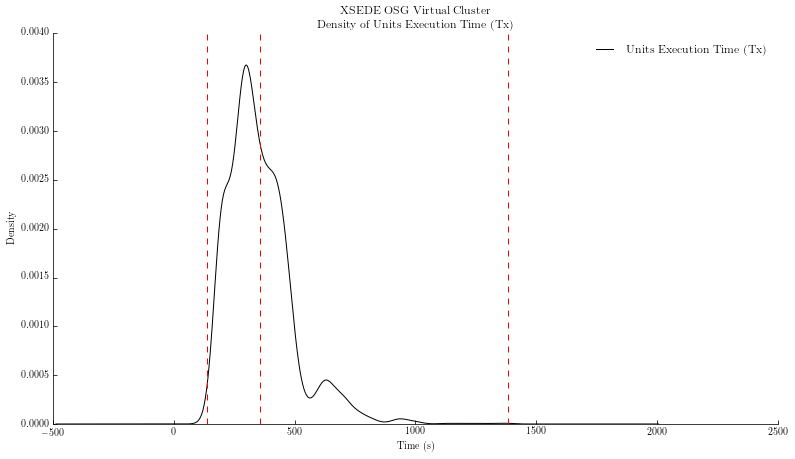

In [64]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)'

tx_all  = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'all': tx_all}) 

utxs.plot.density(ax=ax, color='black', title=title)
plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Time (s)')
ax.legend(labels=['Units Execution Time (Tx)'])

plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

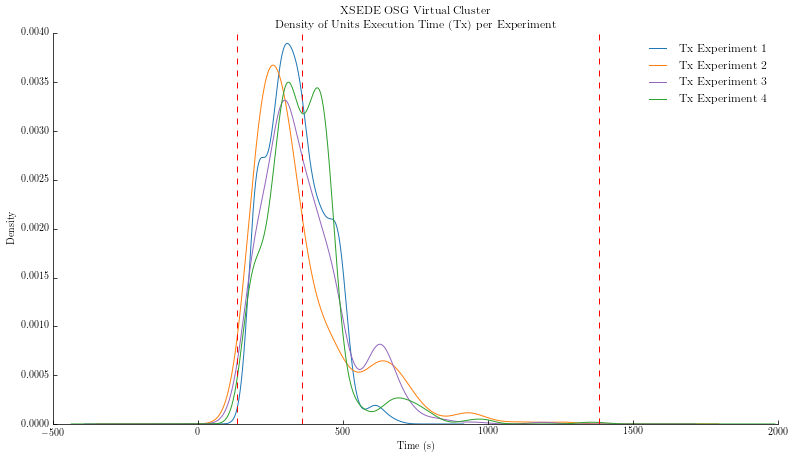

In [67]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment'

tx_exp1 = units[units['experiment'].str.contains('exp1')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp2 = units[units['experiment'].str.contains('exp2')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp3 = units[units['experiment'].str.contains('exp3')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4 = units[units['experiment'].str.contains('exp4')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'exp1': tx_exp1, 'exp2': tx_exp2,  'exp3': tx_exp3, 'exp4': tx_exp4})

utxs.plot.density(ax=ax, color=[tableau20[0],tableau20[2],tableau20[8],tableau20[4]], title=title)
plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Time (s)')
ax.legend(labels=['Tx Experiment 1','Tx Experiment 2','Tx Experiment 3','Tx Experiment 4'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

In [94]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_all = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()

txd_shf1 = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).sample(n=ntx/4).describe()
txd_shf2 = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).sample(n=ntx/4).describe()
txd_shf3 = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).sample(n=ntx/4).describe()
txd_shf4 = units['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True).sample(n=ntx/4).describe()    

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1, 
                                    'exp2': txd_exp2, 
                                    'exp3': txd_exp3, 
                                    'exp4': txd_exp4,
                                    'shf1': txd_shf1,
                                    'shf2': txd_shf2,
                                    'shf3': txd_shf3,
                                    'shf4': txd_shf4})

tx_exp_descriptions

,all,exp1,exp2,exp3,exp4,shf1,shf2,shf3,shf4
count,2416.000000,464.000000,416.000000,544.000000,992.000000,604.000000,604.000000,604.000000,604.000000
mean,357.872151,338.558227,355.217462,366.800878,363.122940,354.513104,357.185018,355.904029,352.606402
std,139.016139,98.210540,174.747996,145.228149,134.146061,143.534047,138.688079,135.830543,136.347498
min,136.134200,191.190400,185.204400,136.134200,170.191000,164.159900,164.159900,138.139000,138.139000
25%,269.269825,270.311050,237.678925,275.037775,283.034000,255.409750,263.888800,268.053075,266.285425
50%,329.670650,328.333200,299.423700,332.309950,345.471950,329.030650,328.237250,328.237800,325.315850
75%,424.391100,408.390325,415.966475,442.786625,424.686200,419.162575,423.683925,421.425600,417.981300
max,1382.527900,674.719000,1258.610500,1189.620700,1382.527900,1382.527900,1189.620700,953.971000,1258.610500


In [21]:
for sid in sessions.index:
#     print sessions.ix[sid, 'session'].describe('relations', ['pilot', 'unit'])
    break

for uix in units.index:
    uid = units.ix[uix, 'uid']
    sid = units.ix[uix, 'sid']
    purel = sessions.ix[sid, 'session'].describe('relations', ['pilot', 'unit'])
    for pid in purel.keys():
        if uid in purel[pid]:
            domain = pilots[(pilots['sid']==sid) & (pilots['pid']==pid)]['domain'].values
            if len(domain) != 1:
                print "Error: filter on session and pilot id returned multiple domains"
                break
            units.ix[uix, 'pilotid'] = pid
            units.ix[uix, 'hostid'] = domain[0]

units

,UNIT_AGENT_EXECUTING,experiment,sid,uid,pilotid,hostid
0,210.2204,exp1,rp.session.radical.mingtha.017033.0007,unit.000009,pilot.0002,ucsd.edu
1,239.5106,exp1,rp.session.radical.mingtha.017033.0007,unit.000008,pilot.0002,ucsd.edu
2,249.2585,exp1,rp.session.radical.mingtha.017033.0007,unit.000010,pilot.0001,phys.uconn.edu
3,294.9099,exp1,rp.session.radical.mingtha.017033.0007,unit.000002,pilot.0001,phys.uconn.edu
4,214.2163,exp1,rp.session.radical.mingtha.017033.0007,unit.000012,pilot.0002,ucsd.edu
5,197.2057,exp1,rp.session.radical.mingtha.017033.0007,unit.000013,pilot.0003,ucsd.edu
6,205.2098,exp1,rp.session.radical.mingtha.017033.0007,unit.000014,pilot.0002,ucsd.edu
7,342.1608,exp1,rp.session.radical.mingtha.017033.0007,unit.000015,pilot.0000,b7c6cf8a3ae1.172.19.0.3
8,193.1973,exp1,rp.session.radical.mingtha.017033.0007,unit.000005,pilot.0003,ucsd.edu
9,283.2868,exp1,rp.session.radical.mingtha.017033.0007,unit.000006,pilot.0001,phys.uconn.edu


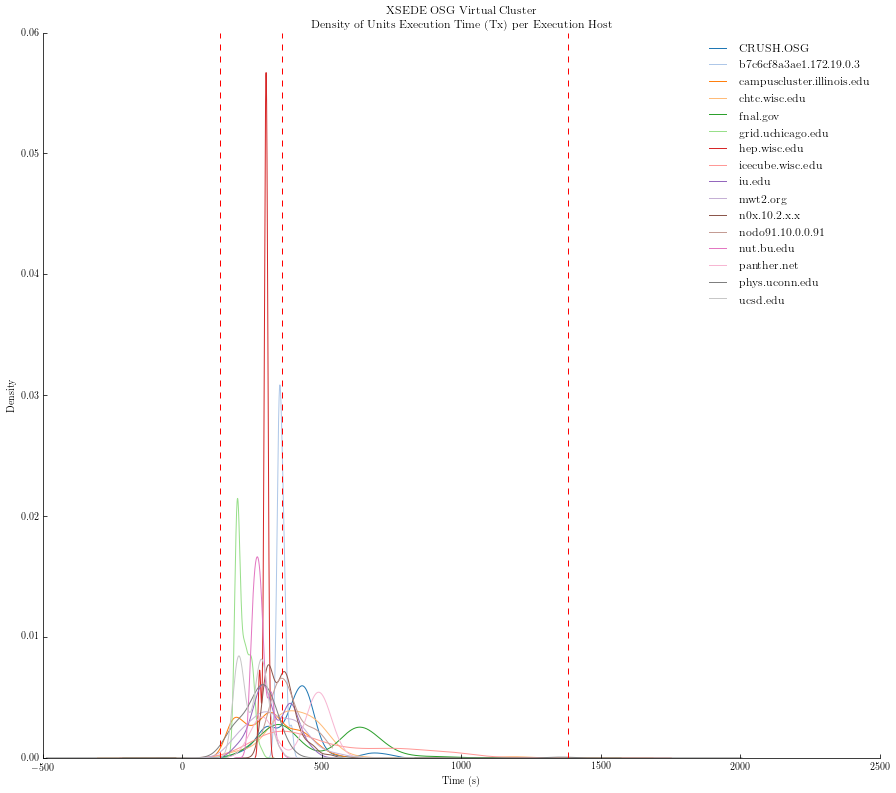

In [66]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Execution Host'

curves = {}
hosts = units['hostid'].dropna().unique()

for host in hosts:
    curves[host] = units[units['hostid'] == host]['UNIT_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxh = pd.DataFrame(curves) 

utxh.plot.density(ax=ax, sort_columns=True, title=title, color=tableau20, figsize=(15, 13)) # subplots=True, layout=(4,4), sharey=True, sharex=True,
plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Time (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

# Time to Completion

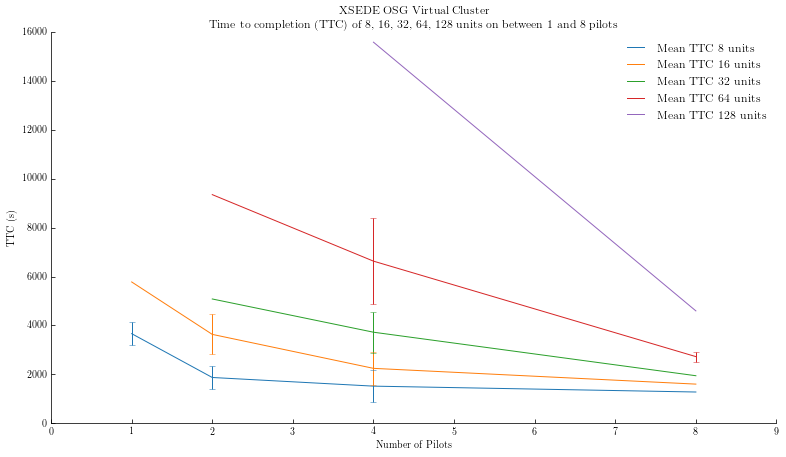

In [272]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nTime to completion (TTC) of 8, 16, 32, 64, 128 units on between 1 and 8 pilots'

nu = None
nus = None
nump = None
index = None
ttc_npilot = None
ttc_npilot_std = None

# index = sessions['npilot_active'].astype(int).sort_values().unique()
# index = np.hstack((index,np.array(index[-1]+1)))

index = np.ndarray(shape=(6), buffer=np.array([0,1,2,4,8,9]), dtype=int) 
ttc_npilot = pd.DataFrame(index=index)
ttc_npilot_std = pd.DataFrame(index=index)

nus = sessions['nunit'].unique()
nus.sort()

for nu in nus:
    s1 = sessions[sessions['nunit'] == nu][['TTC','nunit','npilot_active']].dropna().reset_index(drop=True)
    # for nump in s1['npilot_active'].unique():
    for nump in index:
        s2 = s1[s1['npilot_active'] == nump]
        ttc_npilot.ix[nump, 'Mean TTC '+str(int(nu))+' units'] = s2['TTC'].mean()
        ttc_npilot_std.ix[nump, 'Mean TTC '+str(int(nu))+' units'] = s2['TTC'].std()

# display(ttc_npilot)
# display(ttc_npilot_std)
        
ttc_npilot.plot(ax=ax, yerr=ttc_npilot_std, color=[tableau20[0], 
                                                   tableau20[2], 
                                                   tableau20[4],
                                                   tableau20[6],
                                                   tableau20[8]], title=title)
ax.set_xlabel('Number of Pilots')
ax.set_ylabel('TTC (s)')

plt.savefig('figures/osg_ttc_pilots.pdf', dpi=600, bbox_inches='tight')